# Bridging Neural Dynamics: extending TRFs - Part 2 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Hugo-W/CNSP25_tutorial_HWeissbart/main/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hugo-W/CNSP25_tutorial_HWeissbart/blob/main/notebooks/part_2.ipynb)


This time let's load some real MEG data and try our freshly designed feature-based Phase-Amplitude Coupling extraction. If time allows, will move onto trying to disentangle brain response to acoustic edges around uncertain vs more certain words, to see whether top-down linguistic information affects lower level envelope tracking.

### Setup (Google Colab only)

> We need an extra step to make sure widgets can work in Collab notebooks, uncomment and run the cell bellow if using Google Collab, otherwise just skip this.

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %pip install -q ipywidgets ipympl
    %pip install -q natmeeg mne
    print("🔁 Restarting kernel to use newly installed packages... Just wait that the kernel restarts, then start by running the cell below.")
    get_ipython().kernel.do_shutdown(True) # type: ignore

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False
  
# Download `utils`
if IN_COLAB:
    import requests
    import os

    files = ['__init__.py', 'helpers.py', 'surrogate.py', 'visu.py', 'utils.py']
    # Create utils directory if it doesn't exist
    os.makedirs('utils', exist_ok=True)
    for f in files:
        url = f'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/utils/{f}'
        response = requests.get(url)

        with open(f'utils/{f}', 'wb') as f:
            f.write(response.content)

    # Also download mpl-tstyle:
    url = 'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/notebooks/dark.mplstyle'
    response = requests.get(url)
    with open('./dark.mplstyle', 'wb') as f:
       f.write(response.content)

    from google.colab import output # type: ignore
    output.enable_custom_widget_manager()

## Imports and Data download

First let's get all the libraries, data and path setup.

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import sys, os
from typing import List

import mne

# Add utils to Python path
sys.path.append('..') # access to utils.py and visu.py modules
from utils.utils import download_file, list_h5_data, normalize_complex

dark_bg = True
if dark_bg:
    plt.style.use('dark.mplstyle')

%matplotlib inline

The cell below will download the data if they are not already present in the `data/` folder.

In [ ]:
data_dir = "../data/"
files = {
    "sub-001/audioBook-filtered-ICAed-raw.fif": "https://osf.io/download/689ca8ab66c0f8121bd5a0fd/",
    "sub-001/audioBook-eve.fif": "https://osf.io/download/d7phu/",
    "sub-001/noise-cov.fif": "https://osf.io/download/689ca6fa89cdf5804c13c704/",
    "stim/predictors.hdf5": "https://osf.io/download/68b3114c95a919eba5fe1c79/"
}
# Bad channels: MLF12, MRC55, MRF61

for file_name, url in files.items():
    file_path = os.path.join(data_dir, file_name)
    # Check if the data directory exists, if not create it
    if not os.path.exists(os.path.join(data_dir, os.path.dirname(file_name))):
        os.makedirs(os.path.join(data_dir, os.path.dirname(file_name)))

    # Check if the file already exists
    if not os.path.exists(file_path):
        print(f"{file_name} not found. Downloading...")
        download_file(url, file_path)
    else:
        print(f" ✅ File {file_name} already exists in the {data_dir} directory.")

 ✅ File sub-001/audioBook-filtered-ICAed-raw.fif already exists in the ../data/ directory.
 ✅ File sub-001/audioBook-eve.fif already exists in the ../data/ directory.
 ✅ File sub-001/noise-cov.fif already exists in the ../data/ directory.
 ✅ File stim/predictors.hdf5 already exists in the ../data/ directory.


Let's have a look into the HDF5 file of stimulus features:

In [3]:
list_h5_data("../data/stim/predictors.hdf5", max_depth=4)

transcripts_v2
├── 100
│   ├── acoustic
│   │   ├── ANGE_part1_normalized (27402,)
│   │   ├── Anderson_S01_P01_normalized (29800,)
│   │   ├── Anderson_S01_P02_normalized (31770,)
│   │   ├── Anderson_S01_P03_normalized (28900,)
│   │   ├── Anderson_S01_P04_normalized (35080,)
│   │   ├── BALL_part1_normalized (29801,)
│   │   ├── EAUV_part1_normalized (34382,)
│   │   ├── EAUV_part2_normalized (36153,)
│   │   ├── grimm_20_1_normalized (36659,)
│   │   ├── grimm_20_2_normalized (40055,)
│   │   ├── grimm_23_1_normalized (30309,)
│   │   ├── grimm_23_2_normalized (33287,)
│   │   ├── grimm_23_3_normalized (30292,)
│   ├── wordlevel
│   │   ├── ANGE_part1_normalized (27402, 9)
│   │   ├── Anderson_S01_P01_normalized (29800, 9)
│   │   ├── Anderson_S01_P02_normalized (31770, 9)
│   │   ├── Anderson_S01_P03_normalized (28900, 9)
│   │   ├── Anderson_S01_P04_normalized (35080, 9)
│   │   ├── BALL_part1_normalized (29801, 9)
│   │   ├── EAUV_part1_normalized (34382, 9)
│   │   ├── EAUV_par

We can see that the stimulus feature file `predictors.hdf5` contains a matrix of feature per story, organised under two keys: `acoustic` and `wordlevel`. The former contains the smooth continuous feature (only envelop here), while the latter contains impulse-like time series of word-level features. 

We can also observe that word level features are matrices with 9 columns. These map to the following features (in that order):

- Always on feature
    - word onset
- Valued features
    - surprisal
    - entorpy
    - KL divergence
    - prediction error (= surprisal weighted by precision ~1/entropy)
    - word frequency
    - depth in constituency tree
    - number of closing branches for current word
    - number of opening branches for current word

## Read in stimulus features

In [2]:
from utils.utils import get_feature_signal, STORY_IDs, storynames

In [130]:
subject = 'sub-003'
events = mne.read_events(f'../data/{subject}/audioBook-eve.fif')

Load stimulus features
Loading feature signal for : ['acoustic', 'wordonsets']
Done. X shape: (29800, 2)


Text(0.5, 1.0, 'Features for story: Anderson_S01_P01')

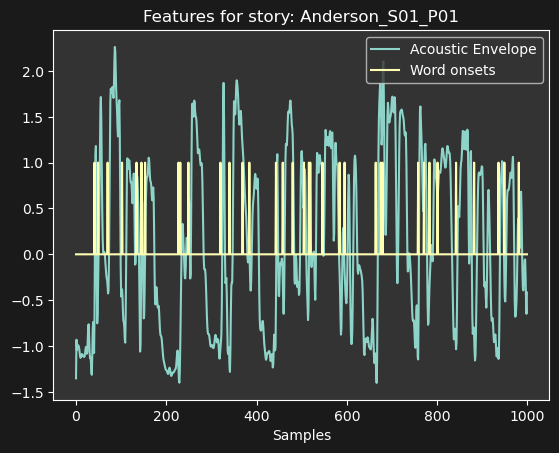

In [131]:
# Loading features:
X = get_feature_signal(normalise=None) # By default, loads envelope and word onsets

# Visualisation
story_id = 0
lines = plt.plot(X[story_id][:100*10, :])
plt.legend(lines, ['Acoustic Envelope', 'Word onsets'])
plt.xlabel('Samples')
plt.title(f'Features for story: {storynames[story_id].strip('_normalized')}')

In [132]:
def story_to_triggers(story):
    """
    Returns trigger onset and offset values.

    Parameters
    ----------
    story : str
        Story part name (e.g. "Anderson_S01_P01_normalized")

    Returns
    -------
    tuple (int, int)
        Onset and offset event ids for this story.

    """
    id_story = {v:k for k,v in STORY_IDs.items()}
    sid = str(id_story[story])
    return int('1' + sid[::-1]), int('2' + sid[::-1])

def get_story_sample_onsets(events, fs_eve=200, sample=False):
    "Returns onset of stories given an `events` input: if sample is True give the exact sample index, otherwise gives time of story onset"
    id_story = {v:k for k,v in STORY_IDs.items()}
    onsets = {}
    for s in id_story:
        trig = story_to_triggers(s)[0]
        onsets[s] = events[np.where(events[:, 2] == trig)[0][0]][0]
        if not sample:
            onsets[s] /= fs_eve
    return onsets

In [133]:
get_story_sample_onsets(events)

{'Anderson_S01_P01_normalized': np.float64(3705.595),
 'Anderson_S01_P02_normalized': np.float64(4063.845),
 'Anderson_S01_P03_normalized': np.float64(4446.615),
 'Anderson_S01_P04_normalized': np.float64(4785.51),
 'grimm_23_1_normalized': np.float64(15.4),
 'grimm_23_2_normalized': np.float64(383.85),
 'grimm_23_3_normalized': np.float64(767.485),
 'grimm_20_1_normalized': np.float64(1873.72),
 'grimm_20_2_normalized': np.float64(2332.685),
 'EAUV_part1_normalized': np.float64(2789.15),
 'EAUV_part2_normalized': np.float64(3244.12),
 'ANGE_part1_normalized': np.float64(1502.76),
 'BALL_part1_normalized': np.float64(1128.16)}

## Read MEG data

In [134]:
import mne
import numpy as np
from utils.utils import normalize_complex

In [ ]:
raw = mne.io.read_raw(f'../data/{subject}/audioBook-filtered-ICAed-raw.fif', preload=True)
raw = raw.pick(mne.channels.channels._picks_to_idx(raw.info, 'meg', with_ref_meg=False))
# raw = raw.pick(meg=True, ref_meg=False)
raw = raw.resample(100)
print(raw._data.shape)

Opening raw data file ../data/sub-003/audioBook-filtered-ICAed-raw.fif...
    Read 5 compensation matrices
    Range : 94854 ... 1122715 =    474.270 ...  5613.575 secs
Ready.
Current compensation grade : 0
Reading 0 ... 1027861  =      0.000 ...  5139.305 secs...
Removing 5 compensators from info because not all compensation channels were picked.


Now we will extract the amplitude of high-frequency component and phase of low frequency component, in order to build the compound analytical signal $z(t) = \rho_{high}e^{i\phi_{low}(t)} \in \mathbb{C}$. We will use this signal to extract the PAC from the continuous signal, based on the Mean Vector Length metric (Canolty et al. (2006)).

As a reminder, for trial-based design, the latter metric is computed as follows:

$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}} |
$$

Working by analogy with how the TRF on raw M/EEG signal exactly recovers ERPs for events that are "well separated", we will compute the TRF on the compound analytical signal $z(t)$ to recover the PAC of different stimulus features.

In [ ]:
compute_pac = True

if compute_pac:
    raise NotImplemented("Fill in the code here to compute the analytical signal of the MEG data.")
else:
    analytical = raw
    analytical.filter(0.5, 12)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.6s


In [ ]:
# # Free up Memory
# if compute_pac:
#     del raw, amp_data, phase_data

Now let's put all snippet of MEG data in a list, ordered according to story names, thus aligned with our features list.

In [ ]:
fs = analytical.info['sfreq']
onsets_per_story = get_story_sample_onsets(events)
X = get_feature_signal(stories=storynames[:9])

def get_meg_list_per_story(story_onsets: dict, feat_list: List[NDArray], fs=100) -> List[NDArray]:
    Y = []
    for k, s in enumerate(storynames[:len(feat_list)]):
        tstart = story_onsets[s]
        start_sample = int(np.round(tstart * fs))
        end_sample = start_sample + len(feat_list[k])
        Y.append(analytical._data.T[start_sample:end_sample]) # Sample first
    return Y

Load stimulus features
Loading feature signal for : ['acoustic', 'wordonsets']
Done. X shape: (29800, 2)


In [ ]:
Y = get_meg_list_per_story(onsets_per_story, X)

## Compute TRF

We will use a handy wrapper around the code seen in part 1 of the tutorial to handle the list of story data efficiently and get some quick plotting functions.

In [ ]:
from pyeeg.models import TRFEstimator
# Call TRFEstimator as `trf = TRFEstimator(tmin=..., tmax=..., srate=..., alpha=...)`
# Then Fit with `trf.fit(X, Y)`, note that X and Y can be list if each element of the list has the same number of samples
# You can plot coefficient with `trf.plot()` which returns a plt.Figure object.

In [ ]:
# Fit and plot the PAC TRF for word onsets, surprisal and entropy.